In [67]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

import sys
sys.path.append("./../../")

from config_reader import ConfigReader
from modules.dvae.model import DVAE
from modules.transformer_gen.ar_cond_1stream.generator import LatentGenerator as LatentGenerator1s
from modules.transformer_gen.ar_cond_2stream.generator import LatentGenerator as LatentGenerator2s
from datasets.mnist_loader import MNISTData
from notebooks.utils import show
from modules.common_utils import latent_to_img
from utilities.md_mnist_utils import LabelsInfo

In [68]:
config_dir_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/finished/'
config_path = config_dir_path + 'trArC2s2s_mnistmd_v256_ds2_nb12_cnb6_remote.yaml'
CONFIG = ConfigReader(config_path=config_path)

In [69]:
data_source = MNISTData(
    img_type=CONFIG.dataset_type,
    root_path=CONFIG.root_path,
    batch_size=CONFIG.BATCH_SIZE)
train_loader = data_source.get_train_loader(batch_size=8)

In [70]:
dvae = DVAE(
    in_channels=CONFIG.in_channels,
    vocab_size=CONFIG.vocab_size,
    num_x2downsamples=CONFIG.num_x2downsamples,
    num_resids_downsample=CONFIG.num_resids_downsample,
    num_resids_bottleneck=CONFIG.num_resids_bottleneck,
    hidden_dim=CONFIG.hidden_dim,
    device=CONFIG.DEVICE)

dvae.eval()
dvae.load_model(
    root_path=CONFIG.vae_model_path,
    model_name=CONFIG.vae_model_name)

In [71]:
G = LatentGenerator2s(
    hidden_width=CONFIG.hidden_width,
    hidden_height=CONFIG.hidden_height,
    embedding_dim=CONFIG.vocab_size,
    num_blocks=CONFIG.num_blocks,
    cond_num_blocks=CONFIG.cond_num_blocks,
    cond_seq_size=CONFIG.cond_seq_size,
    cond_vocab_size=CONFIG.cond_vocab_size,
    hidden_dim=CONFIG.hidden_dim,
    n_attn_heads=CONFIG.n_attn_heads,
    dropout_prob=CONFIG.dropout_prob,
    device=CONFIG.DEVICE)

G.eval()
G.load_model(
    root_path=CONFIG.model_path,
    model_name=CONFIG.model_name)

In [72]:
json_path = '/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/multi_descriptive_MNIST/description/labels_info.json'
li = LabelsInfo(json_path)

In [73]:
img, tokens = next(iter(train_loader))

In [74]:
description = li.decode_ids(tokens.tolist())

description

[['0', '40', 'b', 'middle', '4', '20', 'g', 'down', '2', '30', 'b', 'up'],
 ['8', '20', 'r', 'middle', '2', '40', 'r', 'down', '4', '30', 'b', 'up'],
 ['7', '40', 'w', 'up', '6', '40', 'b', 'down', '7', '40', 'b', 'middle'],
 ['2', '30', 'r', 'up', '6', '20', 'r', 'down', '1', '30', 'g', 'up'],
 ['3', '40', 'r', 'up', '3', '40', 'b', 'down', '7', '30', 'r', 'up'],
 ['5', '40', 'w', 'up', '5', '20', 'r', 'down', '1', '30', 'g', 'up'],
 ['2', '30', 'b', 'up', '5', '20', 'b', 'up', '4', '40', 'w', 'middle'],
 ['2', '40', 'g', 'up', '7', '40', 'b', 'middle', '2', '20', 'r', 'down']]

In [75]:
replace_value = "r"
for i in range(len(description)):
    for j in range(3):
        # color
        description[i][2 + j * 4] = replace_value
        # digit
        #description[i][0 + j * 4] = replace_value
        # location
        #description[i][3 + j * 4] = replace_value

description

[['0', '40', 'r', 'middle', '4', '20', 'r', 'down', '2', '30', 'r', 'up'],
 ['8', '20', 'r', 'middle', '2', '40', 'r', 'down', '4', '30', 'r', 'up'],
 ['7', '40', 'r', 'up', '6', '40', 'r', 'down', '7', '40', 'r', 'middle'],
 ['2', '30', 'r', 'up', '6', '20', 'r', 'down', '1', '30', 'r', 'up'],
 ['3', '40', 'r', 'up', '3', '40', 'r', 'down', '7', '30', 'r', 'up'],
 ['5', '40', 'r', 'up', '5', '20', 'r', 'down', '1', '30', 'r', 'up'],
 ['2', '30', 'r', 'up', '5', '20', 'r', 'up', '4', '40', 'r', 'middle'],
 ['2', '40', 'r', 'up', '7', '40', 'r', 'middle', '2', '20', 'r', 'down']]

In [76]:
description_ids = li.encode_values(description)
description_tensor = torch.LongTensor(description_ids).T.to(CONFIG.DEVICE)

In [77]:
img = img.to(CONFIG.DEVICE)

with torch.no_grad():
    latent = dvae.ng_q_encode(img)
    
    b, emb, h, w = latent.size()
    x = latent.view(b, emb, -1).permute(2, 0, 1)
    
    start_vector = torch.zeros(1, b, emb, device=x.device)
    x_inp = torch.cat([start_vector, x[:-1,:,:]], dim=0)
    
    gen_lat = G.forward(x_inp, description_tensor)

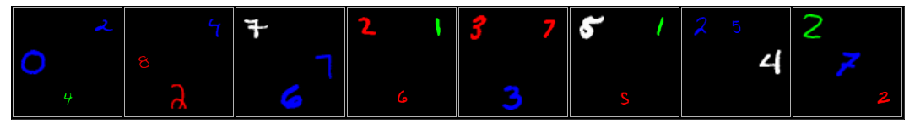

In [78]:
show(img, figsize=(16,16), plot_grid=True)

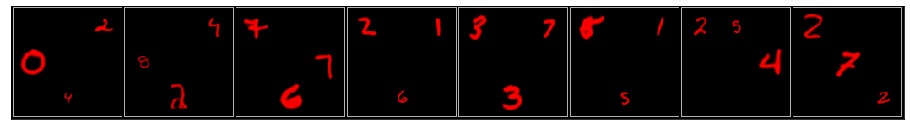

In [79]:
gen_img = latent_to_img(gen_lat, dvae, CONFIG.hidden_height, CONFIG.hidden_width)

show(gen_img, figsize=(16,16), plot_grid=True)